In [1]:
library(Seurat)
library(dplyr)
library(ComplexHeatmap)
library(circlize)
library(SeuratDisk)
library(Seurat)
library(dplyr)
library(ggplot2)
library(ComplexHeatmap)
library(circlize)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effo

In [2]:
#hanifa data 
obj <- LoadH5Seurat("/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/hanifa_data/GITHUB-DATA/SC-RNA-DATA/HANIFFA-DATA/RDS-Files/submission.h5seurat")
#travisdata 

#obj <- readRDS("/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/hanifa_data/GITHUB-DATA/SC-RNA-DATA/TRAVIS-DATA/RDS-Files/Travis_Data_Seurat_Object.RDS")


Validating h5Seurat file

Initializing RNA with data



Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the SeuratDisk package.
  Please report the issue at
  <https://github.com/mojaveazure/seurat-disk/issues>.”
Adding counts for RNA

Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the SeuratDisk package.
  Please report the issue at
  <https://github.com/mojaveazure/seurat-disk/issues>.”
Adding feature-level metadata for RNA

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



In [3]:
# show assays and the active assay
Assays(obj)
DefaultAssay(obj)

[1] "RNA"

[1] "RNA"

Warning message:
“Removing 174729 cells missing data for vars requested”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <93>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversio

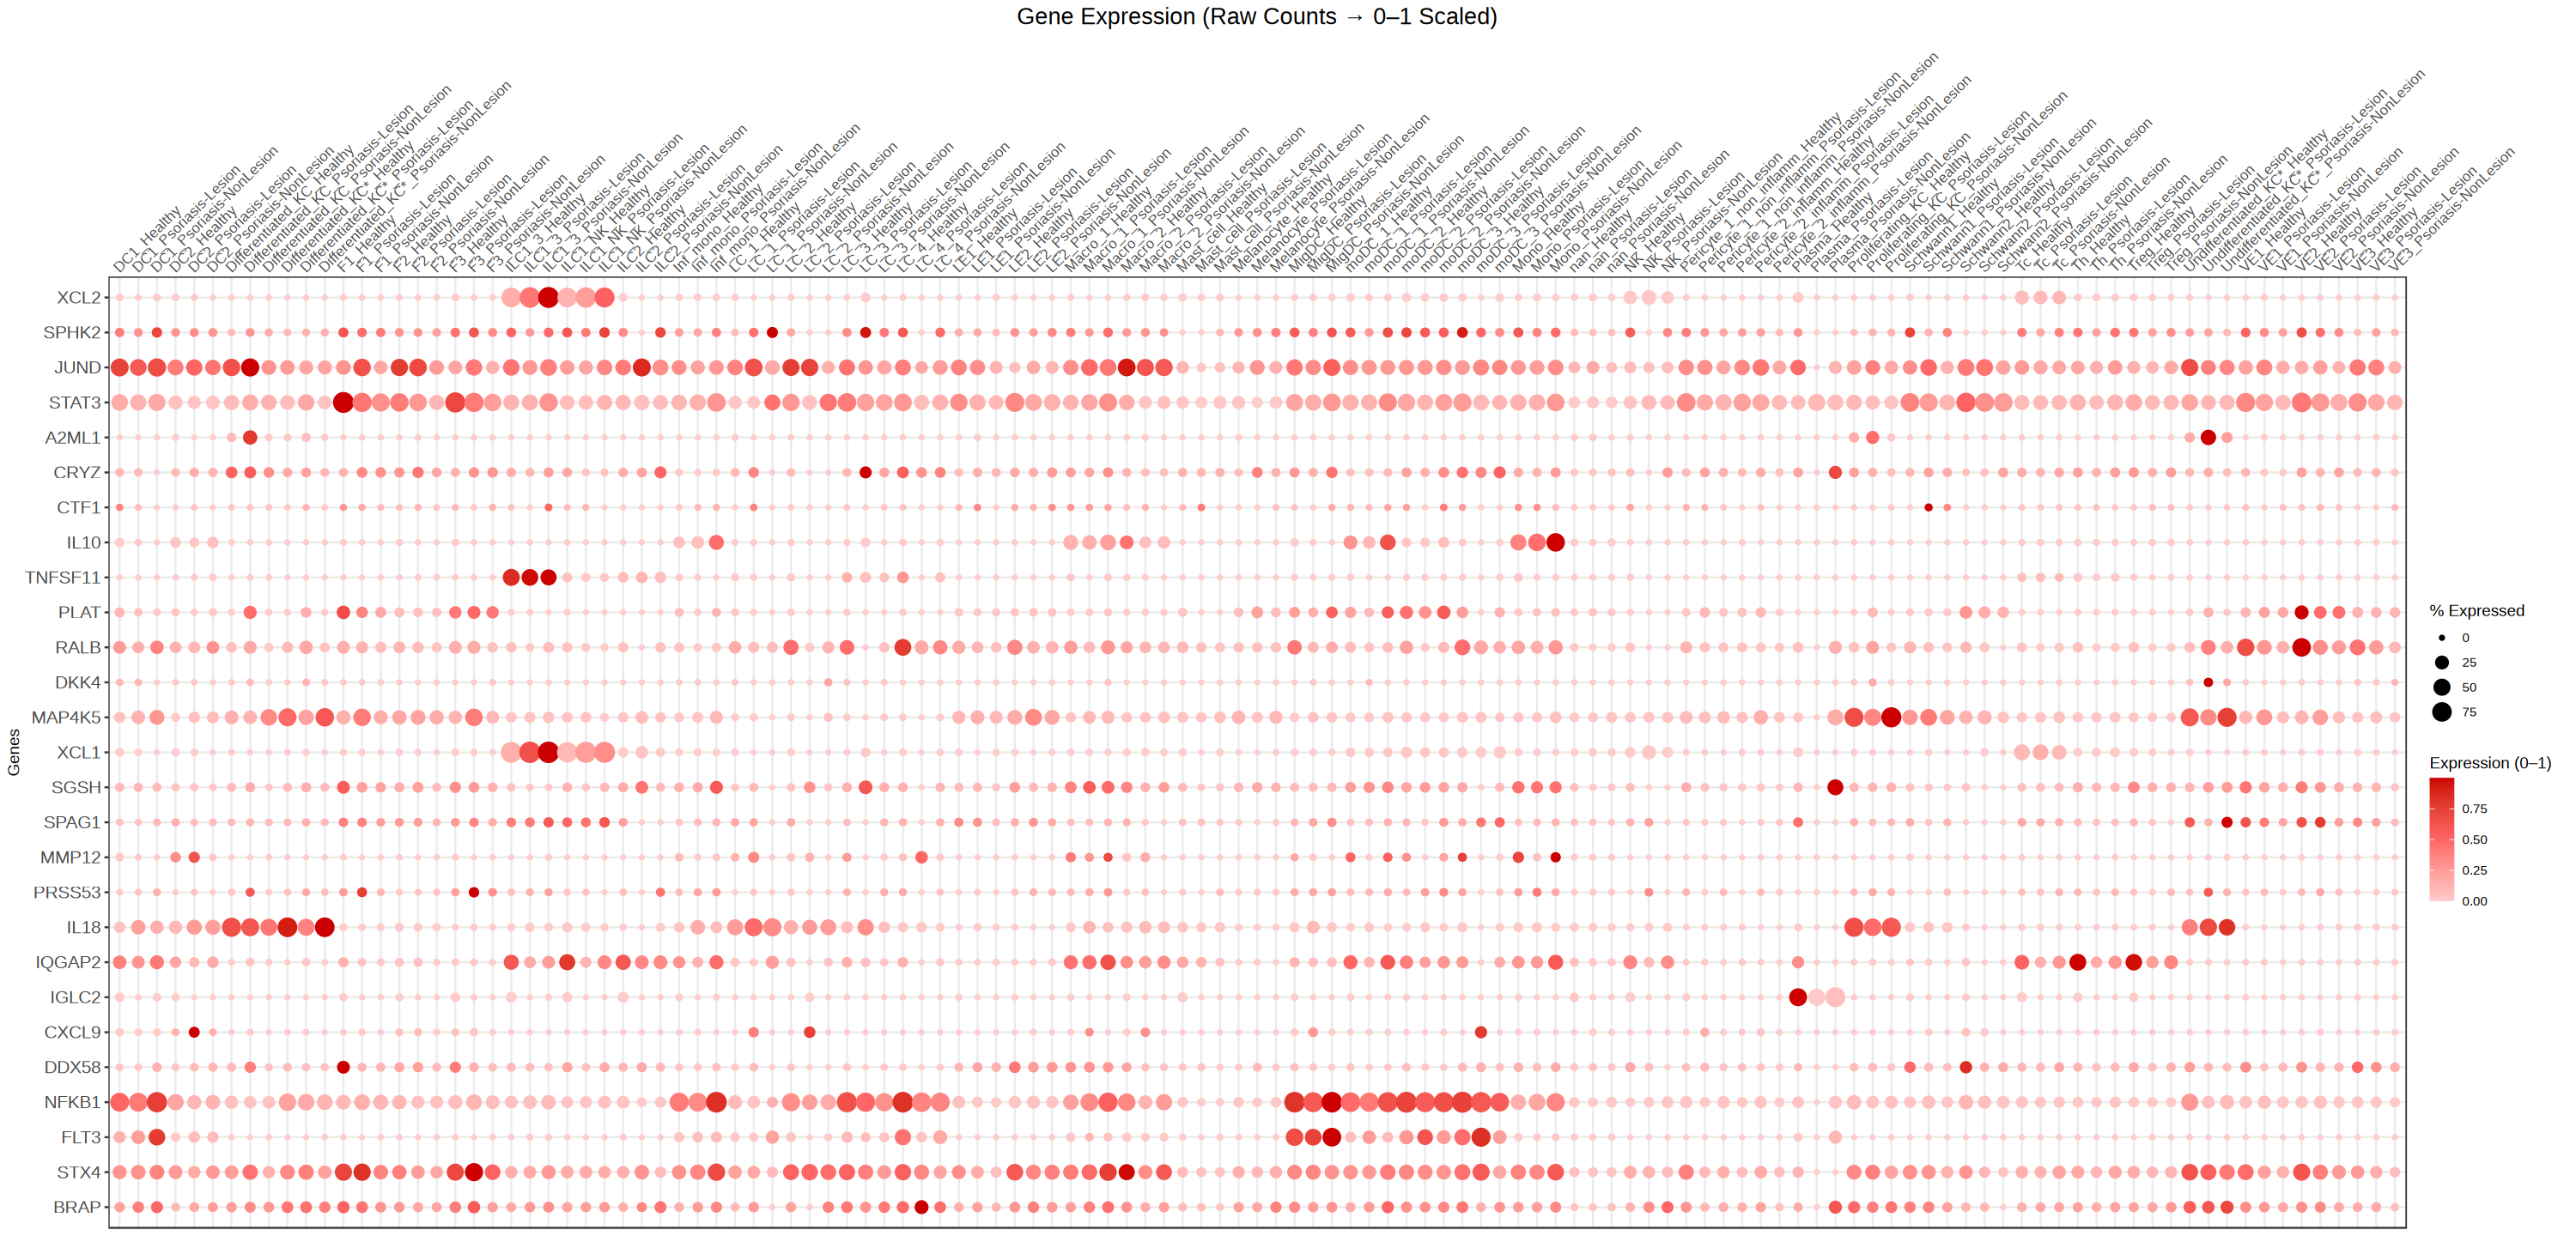

In [4]:
library(Seurat)
library(dplyr)
library(tidyr)
library(ggplot2)

options(repr.plot.width = 26, repr.plot.height = 16)

## ==========================================================
## 1. Genes
## ==========================================================
genes <- c(
  "BRAP","STX4","FLT3","NFKB1","DDX58","CXCL9","IGLC2","IQGAP2","IL18",
  "PRSS53","MMP12","SPAG1","SGSH","XCL1","MAP4K5","DKK4","RALB","PLAT",
  "TNFSF11","IL10","CTF1","CRYZ","A2ML1","STAT3","JUND","SPHK2","XCL2"
)
genes_present <- intersect(genes, rownames(obj))

## ==========================================================
## 2. Setup Condition Labels
## ==========================================================
obj$Condition3 <- NA
obj$Condition3[obj$Status == "Healthy"] <- "Healthy"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "lesion"] <- "Psoriasis-Lesion"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "non_lesion"] <- "Psoriasis-NonLesion"

obj_sub <- subset(obj, Condition3 %in% c("Healthy","Psoriasis-Lesion","Psoriasis-NonLesion"))

## Create combined label
obj_sub$CellType_Condition <- paste0(obj_sub$final_clustering, "_", obj_sub$Condition3)

## ==========================================================
## 3. Extract RAW COUNT DATA
## ==========================================================
cnt <- GetAssayData(obj_sub, assay="RNA", slot="counts")  # sparse matrix

## Keep selected genes only
cnt <- cnt[genes_present, ]

## extract meta (force data.frame!)
meta <- obj_sub@meta.data[, c("CellType_Condition"), drop = FALSE]

## ==========================================================
## 4. Compute mean counts + % cells expressing
## ==========================================================
plot_df <- lapply(genes_present, function(g){

  x <- cnt[g, ]  # counts for gene g

  df <- data.frame(
    CellTypeCondition = meta$CellType_Condition,
    Count = as.numeric(x)
  ) %>%
    group_by(CellTypeCondition) %>%
    summarise(
      Percent = mean(Count > 0) * 100,
      Expression = mean(Count)
    ) %>%
    mutate(Gene = g)

  df
}) %>% bind_rows()

plot_df[is.na(plot_df)] <- 0


## ==========================================================
## 5. Scale EXPRESSION 0–1 per gene (from raw mean counts)
## ==========================================================
plot_df <- plot_df %>%
  group_by(Gene) %>%
  mutate(Expression01 = (Expression - min(Expression)) /
                       (max(Expression) - min(Expression) + 1e-9)
  ) %>%
  ungroup()

## ORDERING
plot_df$Gene <- factor(plot_df$Gene, levels = genes_present)
plot_df$CellTypeCondition <- factor(plot_df$CellTypeCondition,
                                    levels = sort(unique(plot_df$CellTypeCondition)))

## ==========================================================
## 6. DOT PLOT (0–1 scaled from raw counts)
## ==========================================================
p <- ggplot(plot_df, aes(
  x = CellTypeCondition,
  y = Gene,
  size = Percent,
  color = Expression01
)) +
  geom_point() +

  scale_size(range = c(1, 6)) +

  scale_color_gradientn(
    colours = c( "#FFCCCC", "#FF6666", "#CC0000"),
    values = c(0,  0.5, 1)
  ) +

  theme_bw() +
  theme(
    ## MOVE LABELS TO TOP
    axis.text.x       = element_blank(),
    axis.title.x      = element_blank(),
    axis.ticks.x      = element_blank(),

    axis.text.x.top   = element_text(angle = 45, hjust = 0, size = 10),

    axis.text.y       = element_text(size = 12),
    plot.title        = element_text(size = 16, hjust = 0.5)
  ) +
  scale_x_discrete(position = "top") +
  labs(
    title = "Gene Expression (Raw Counts → 0–1 Scaled)",
    x = "Cell Type × Condition",
    y = "Genes",
    size = "% Expressed",
    color = "Expression (0–1)"
  ) 

options(repr.plot.width = 25, repr.plot.height = 12)
p

## ==========================================================
## 7. Save matrices & plot
## ==========================================================
write.csv(plot_df, "dotplot_matrix_rawcounts_scaled01.csv", row.names = FALSE)

ggsave("dotplot_rawcounts_01scale.pdf", p, width = 25, height = 12)
ggsave("dotplot_rawcounts_01scale.png", p, width = 25, height = 12, dpi=300)


In [ ]:
library(Seurat)
library(dplyr)

# ---------------------------------------------
# 1. Your gene list
# ---------------------------------------------
genes <- c(
  "BRAP","STX4","FLT3","NFKB1","DDX58","CXCL9","IGLC2","IQGAP2","IL18",
  "PRSS53","MMP12","SPAG1","SGSH","XCL1","MAP4K5","DKK4","RALB","PLAT",
  "TNFSF11","IL10","CTF1","CRYZ","A2ML1","STAT3","JUND","SPHK2","XCL2"
)

genes_present <- intersect(genes, rownames(obj))


# ---------------------------------------------
# 2. Prepare condition labels
# ---------------------------------------------
obj$Condition3 <- NA
obj$Condition3[obj$Status == "Healthy"] <- "Healthy"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "lesion"] <- "Psoriasis_Lesion"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "non_lesion"] <- "Psoriasis_NonLesion"

# Keep only the 3 groups
obj_sub <- subset(obj, Condition3 %in% c("Healthy","Psoriasis_Lesion","Psoriasis_NonLesion"))

Idents(obj_sub) <- obj_sub$Condition3


# ---------------------------------------------
# 3. DE function with significance class
# ---------------------------------------------
run_de <- function(seu, group1, group2, genes){

  df <- FindMarkers(
    seu,
    ident.1 = group1,
    ident.2 = group2,
    features = genes,
    logfc.threshold = 0,
    test.use = "wilcox",
    assay = "RNA",
    slot = "data"
  )

  df <- df %>%
    mutate(
      Gene = rownames(df),
      Comparison = paste(group1, "vs", group2),
      Significance_Class = case_when(
        p_val_adj < 0.001 ~ "Highly Significant",
        p_val_adj < 0.05  ~ "Significant",
        TRUE              ~ "Not Significant"
      )
    )

  rownames(df) <- NULL
  return(df)
}


# ---------------------------------------------
# 4. Run ALL three comparisons
# ---------------------------------------------
de_H_vs_L  <- run_de(obj_sub, "Psoriasis_Lesion",     "Healthy", genes_present)
de_H_vs_NL <- run_de(obj_sub, "Psoriasis_NonLesion", "Healthy", genes_present)
de_L_vs_NL <- run_de(obj_sub, "Psoriasis_Lesion", "Psoriasis_NonLesion", genes_present)


# ---------------------------------------------
# 5. Combine & Save
# ---------------------------------------------
all_de <- bind_rows(
  de_H_vs_L,
  de_H_vs_NL,
  de_L_vs_NL
)

write.csv(all_de, "DE_results_all_comparisons_with_significance.csv", row.names = FALSE)

all_de


Warning message:
“Removing 174729 cells missing data for vars requested”


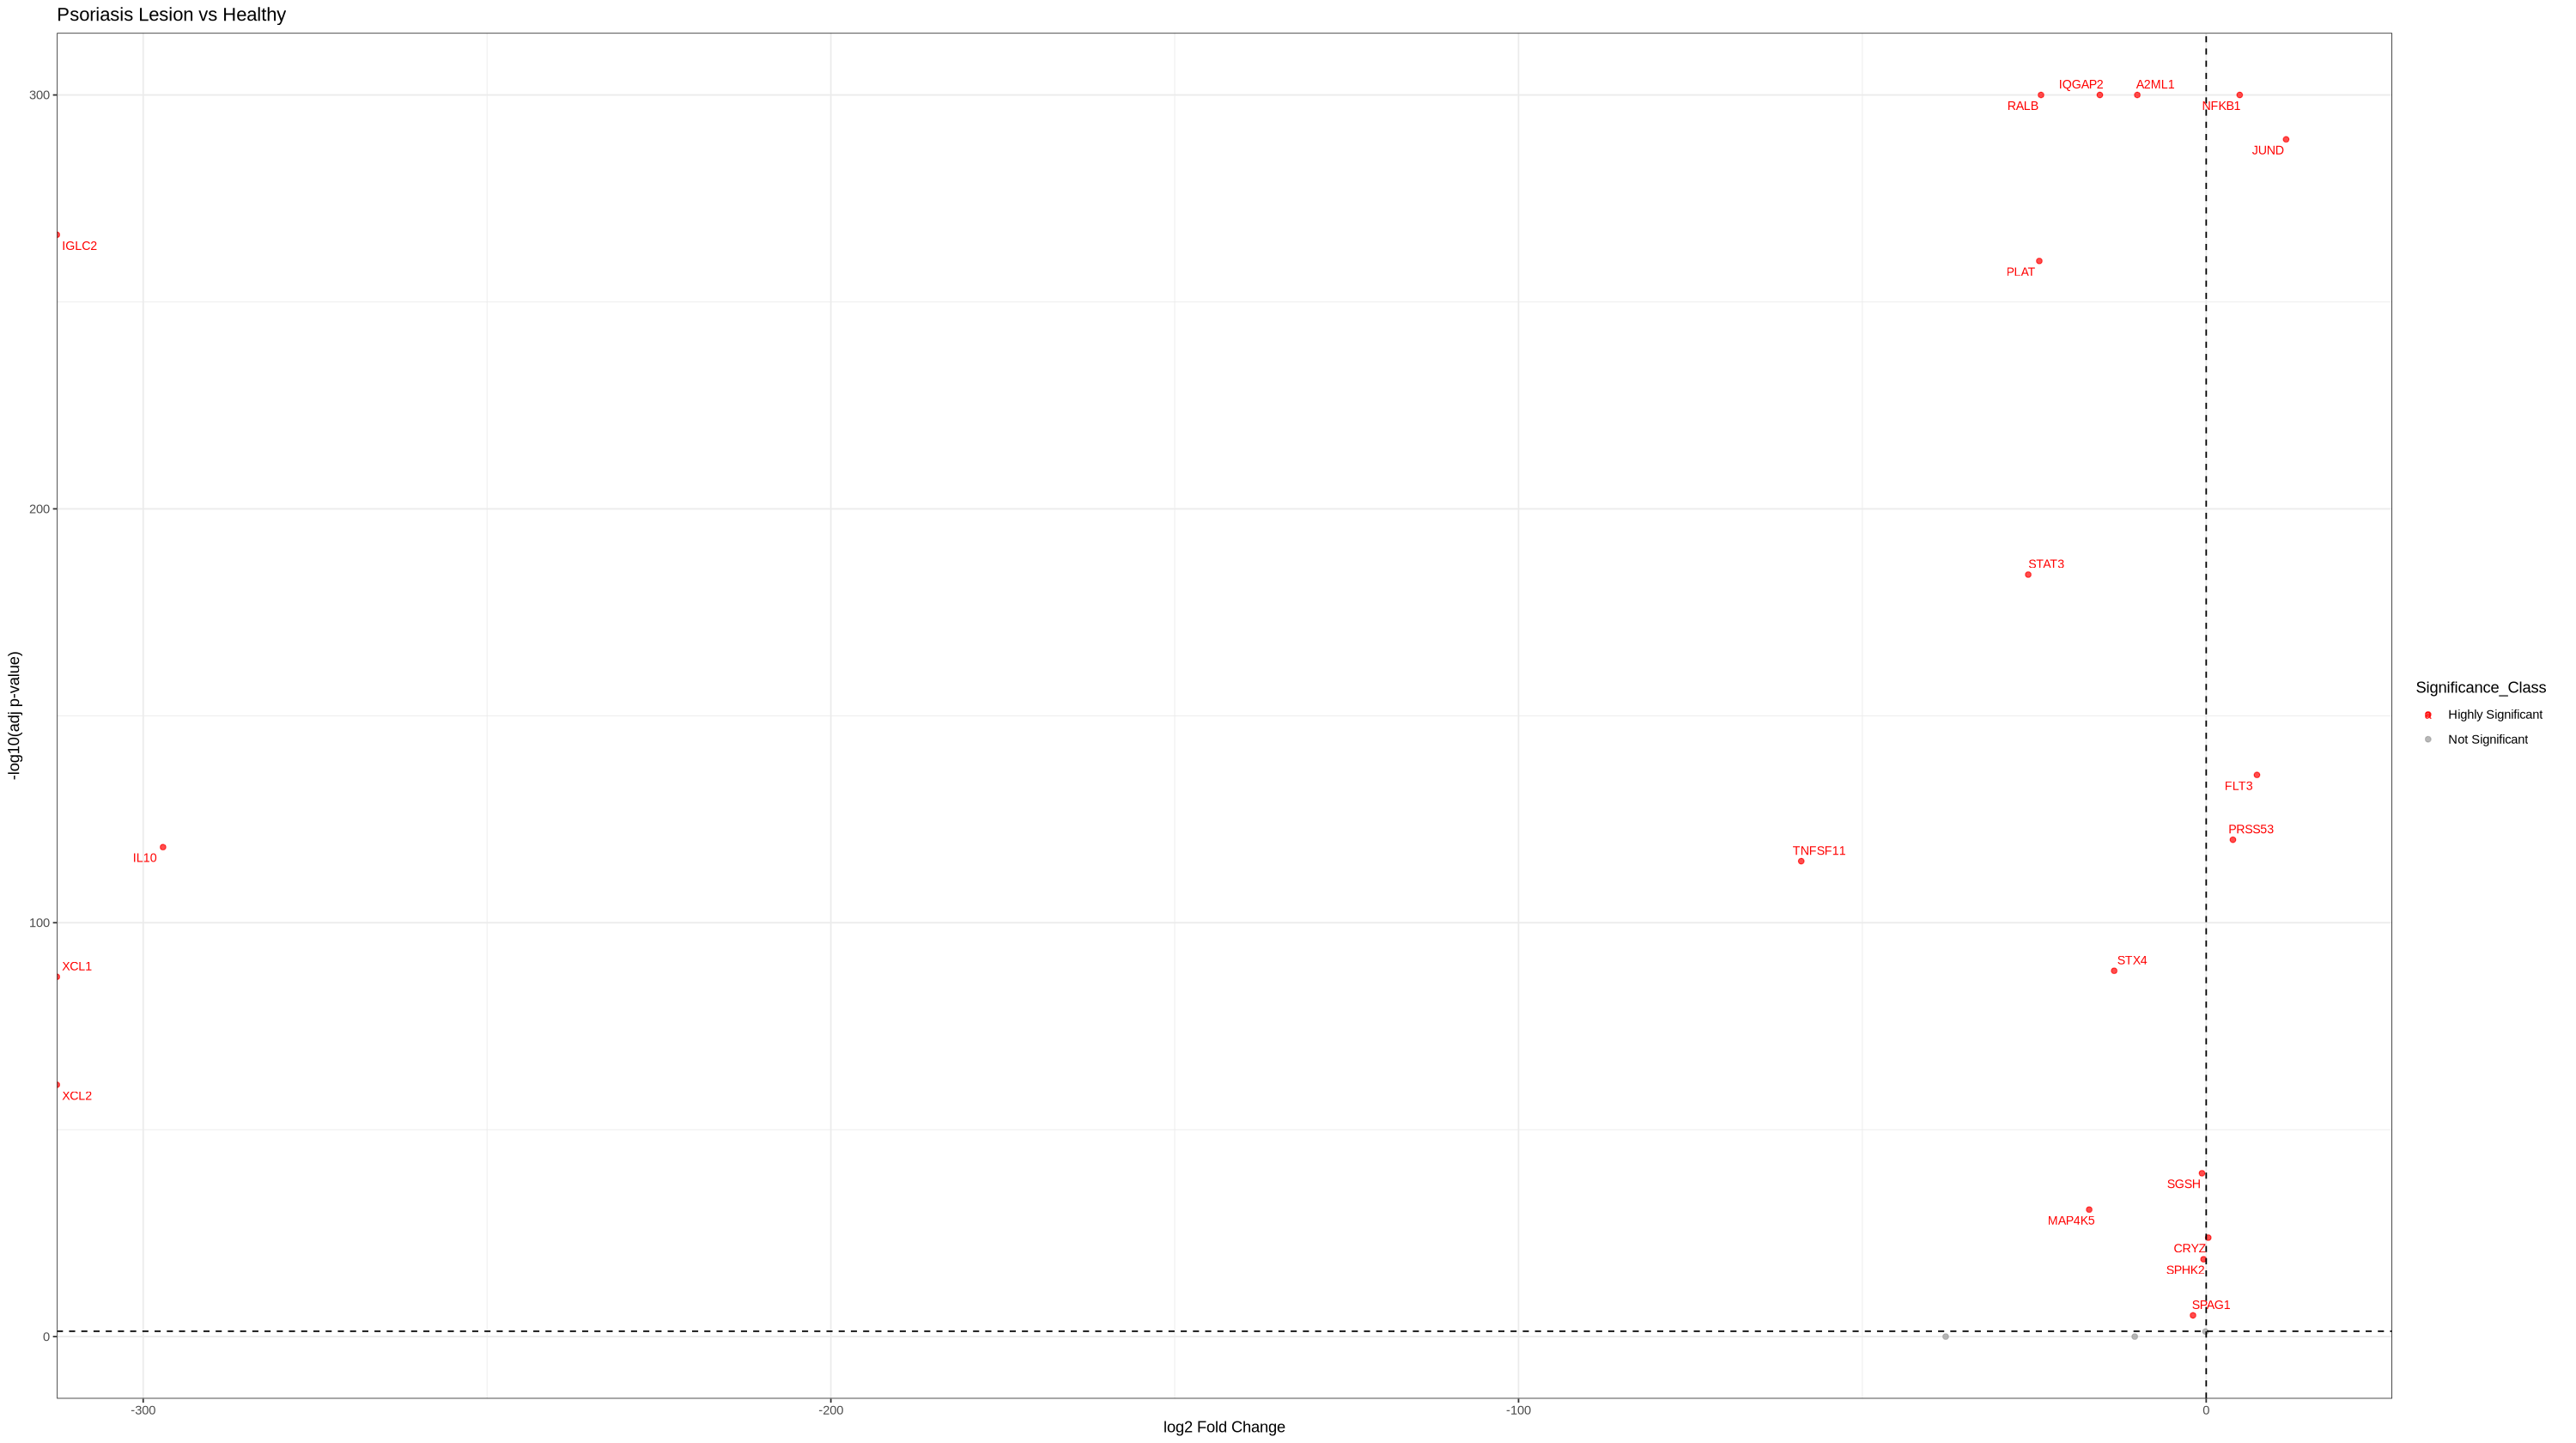

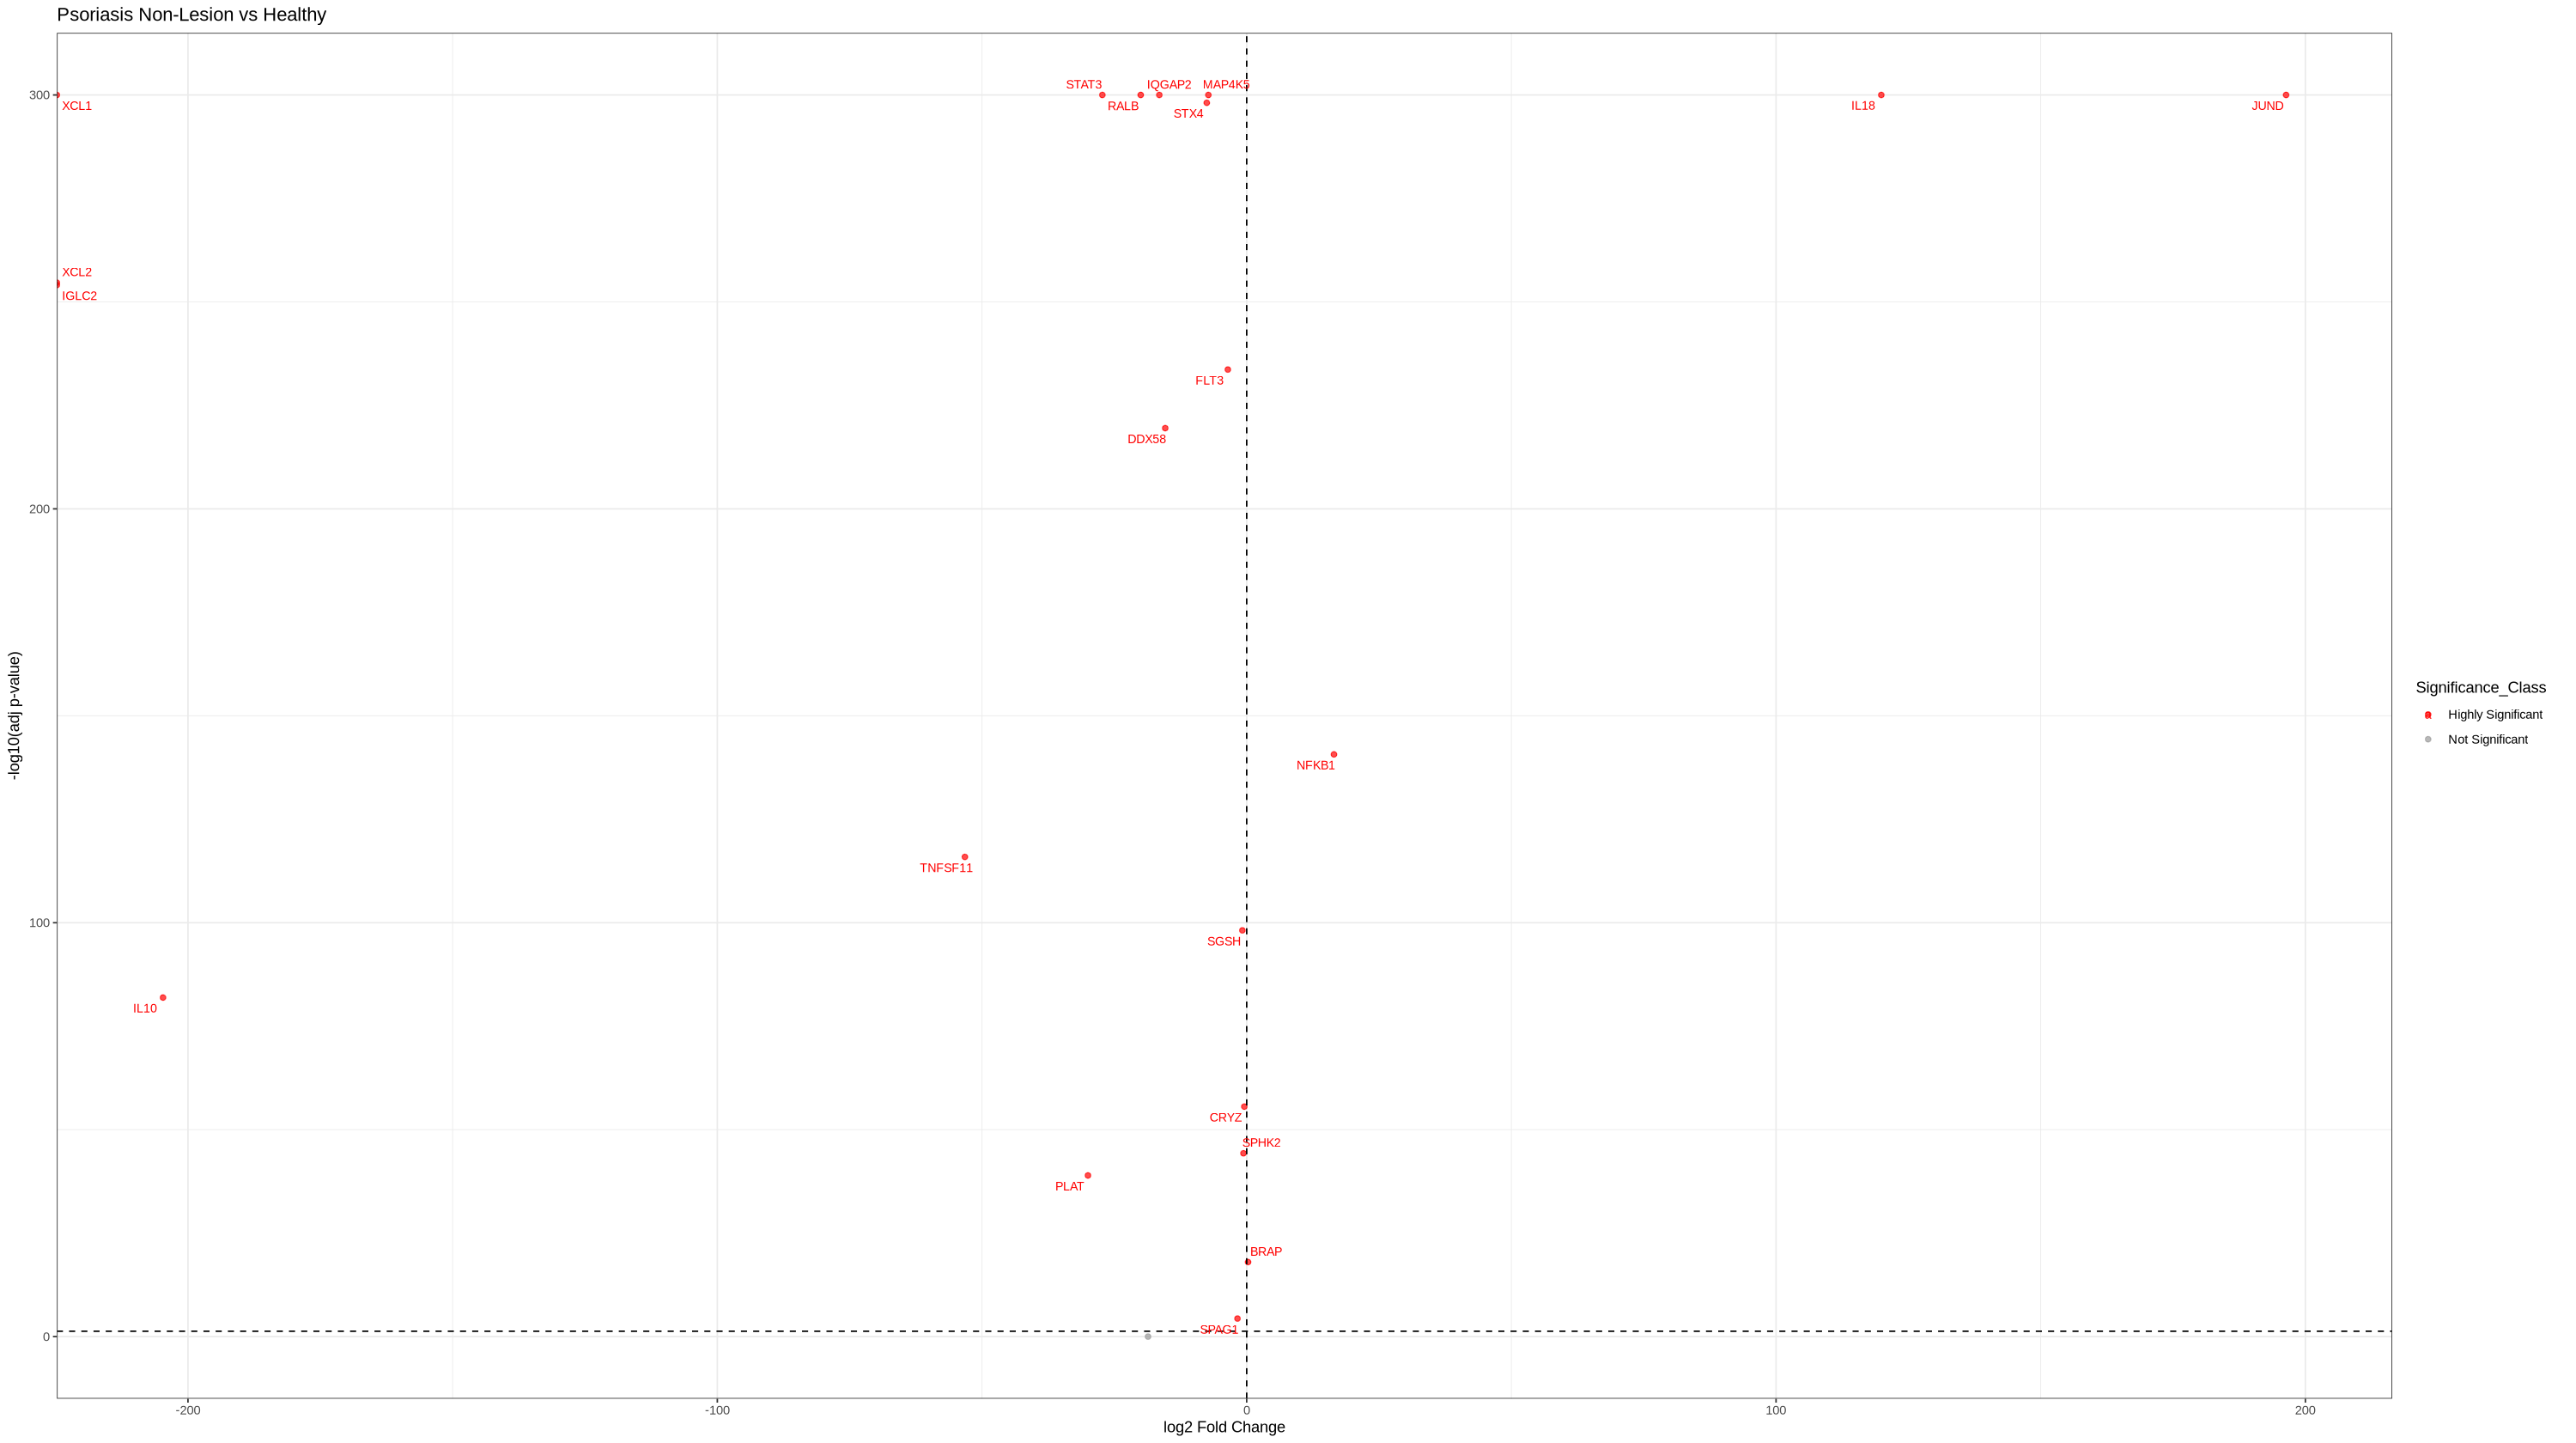

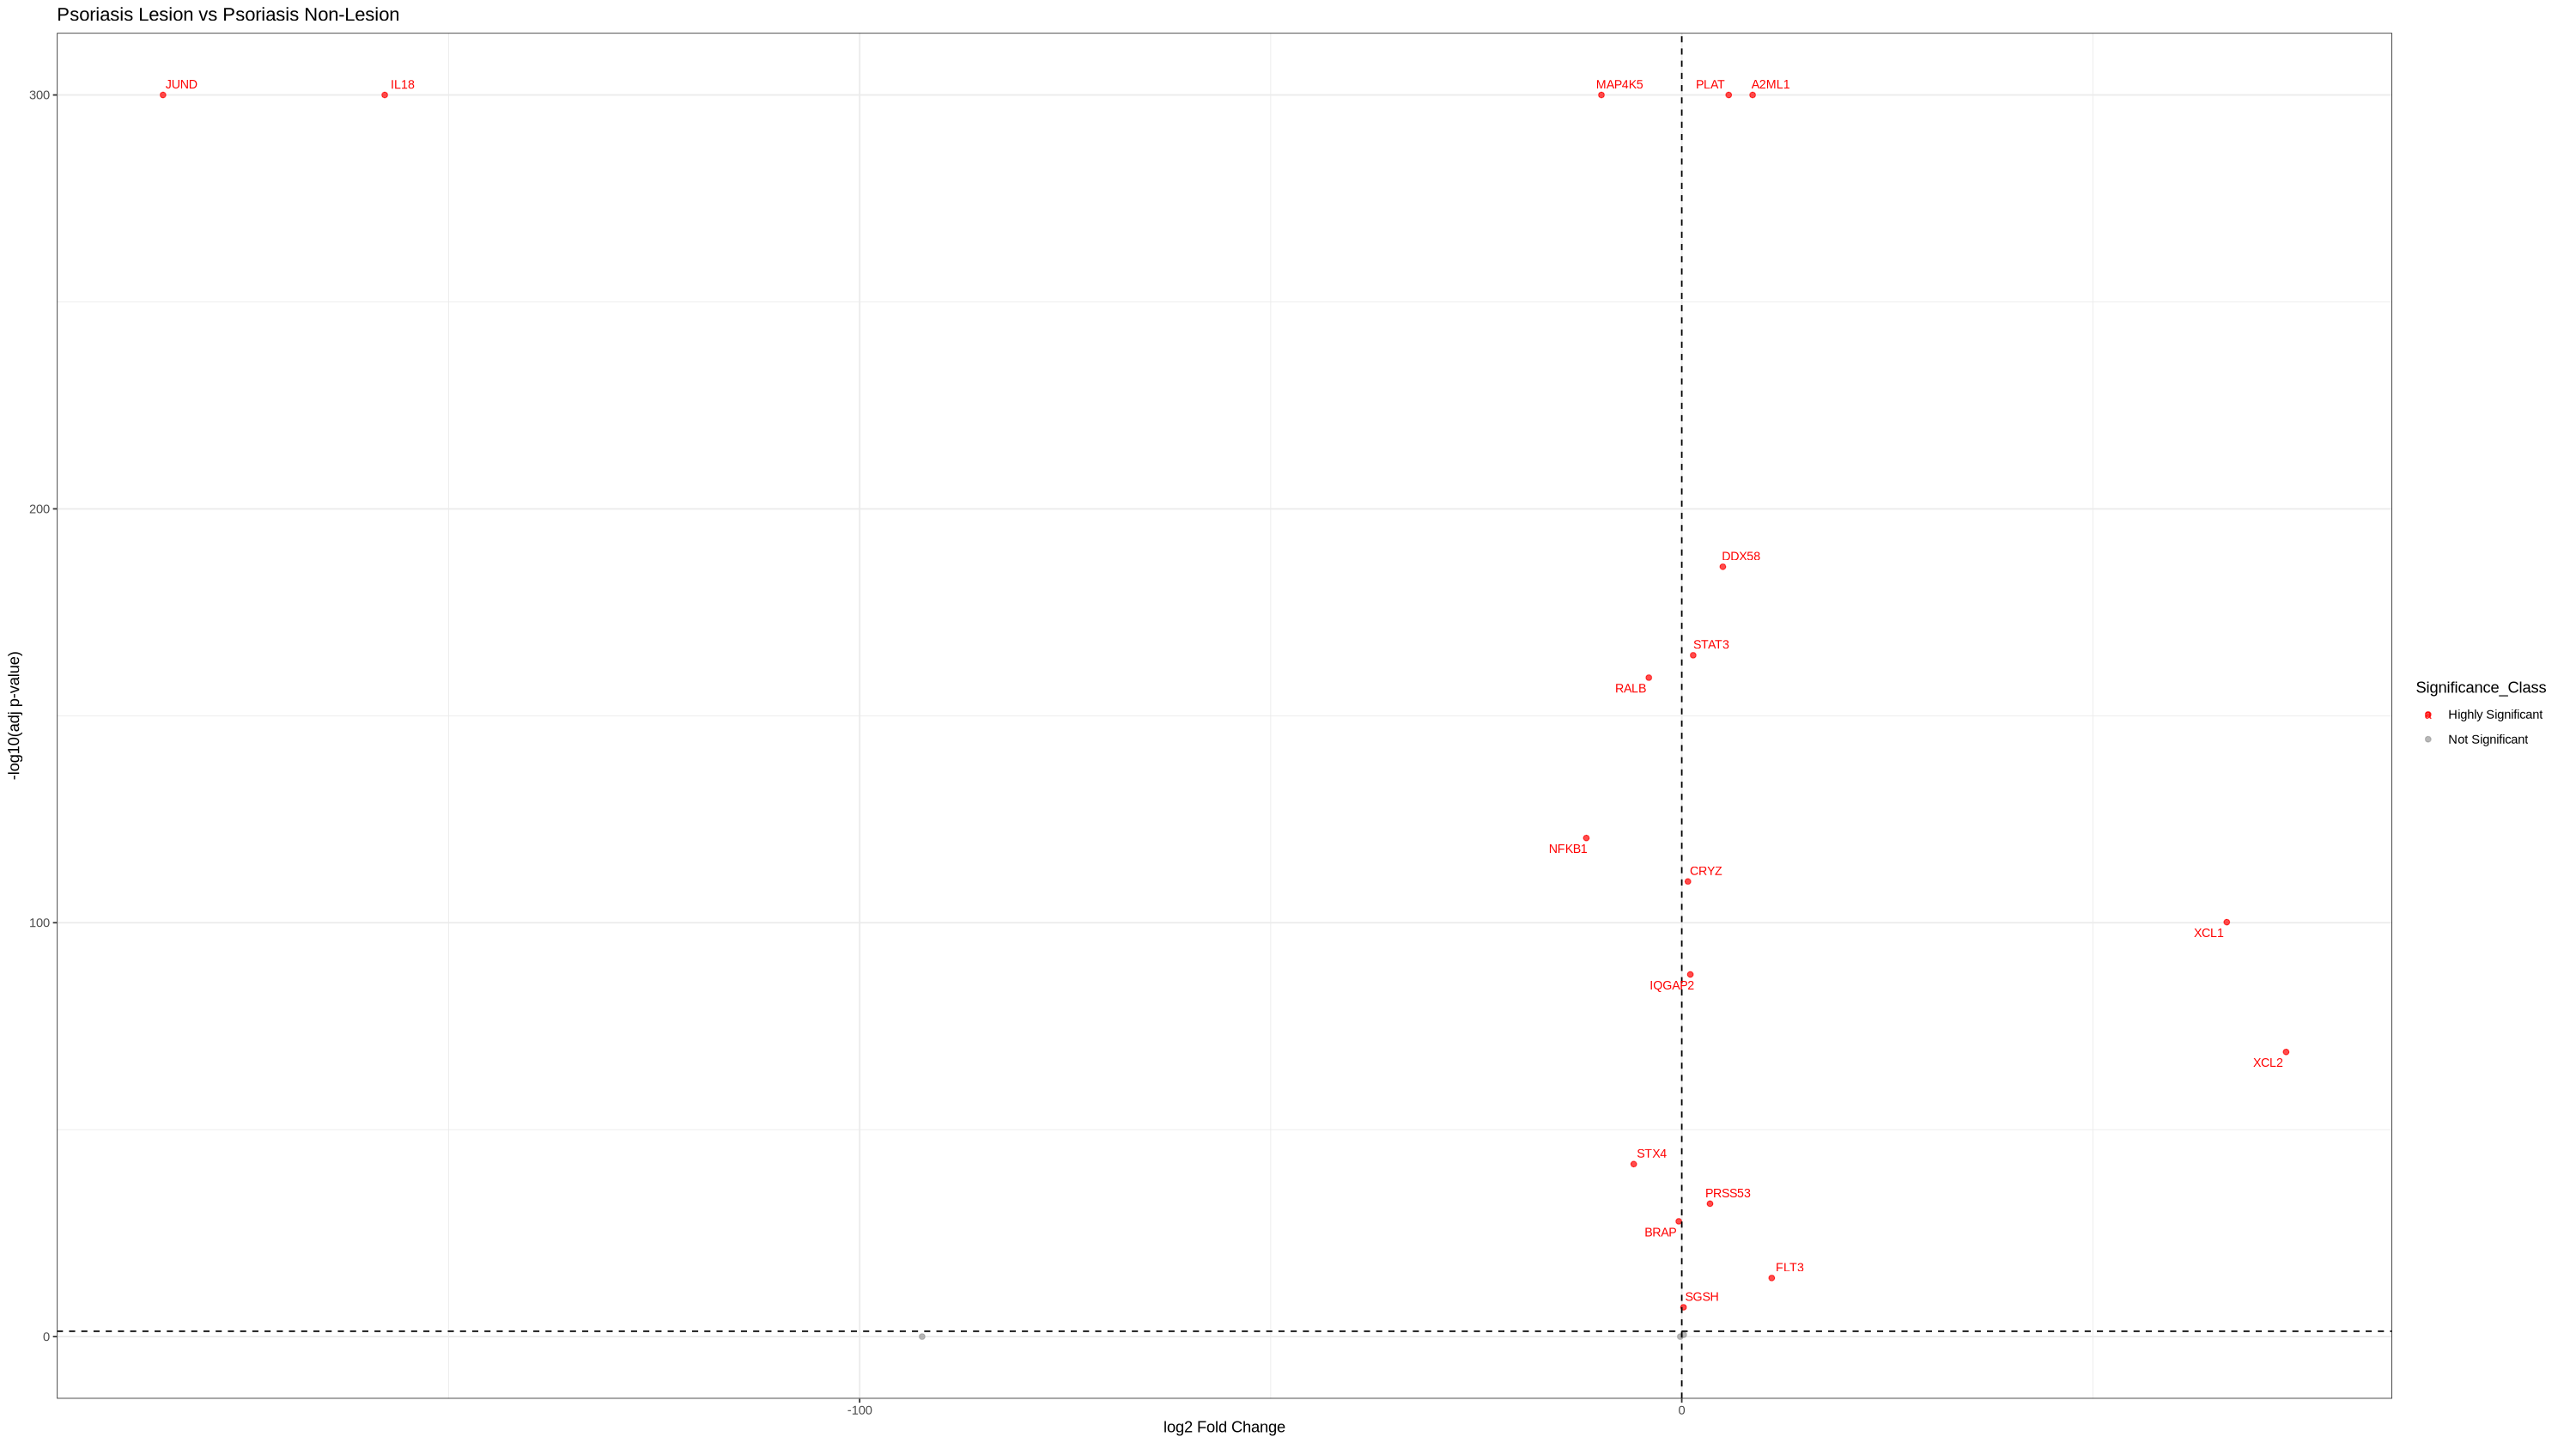

In [ ]:
library(ggplot2)
library(dplyr)
library(ggrepel)

df <- all_de   # your combined DE table

# Fix column names if Seurat added dots
colnames(df) <- gsub("\\.\\.\\.", "", colnames(df))
colnames(df) <- gsub("\\.", "_", colnames(df))

# Volcano plotting function
plot_volcano <- function(subdf, title){
  
  subdf$log10_p <- -log10(subdf$p_val_adj + 1e-300)

  ggplot(subdf, aes(x = avg_log2FC, y = log10_p, color = Significance_Class)) +
    geom_point(alpha = 0.7) +
    scale_color_manual(values = c(
      "Highly Significant" = "red",
      "Significant" = "orange",
      "Not Significant" = "gray60"
    )) +
    geom_vline(xintercept = 0, linetype = 2) +
    geom_hline(yintercept = -log10(0.05), linetype = 2) +
    theme_bw() +
    labs(title = title,
         x = "log2 Fold Change",
         y = "-log10(adj p-value)") +
    geom_text_repel(data = subset(subdf, Significance_Class != "Not Significant"),
                    aes(label = Gene),
                    size = 3, max.overlaps = 20)
}

p1 <- plot_volcano(df %>% filter(Comparison=="Psoriasis_Lesion vs Healthy"),
                   "Psoriasis Lesion vs Healthy")

p2 <- plot_volcano(df %>% filter(Comparison=="Psoriasis_NonLesion vs Healthy"),
                   "Psoriasis Non-Lesion vs Healthy")

p3 <- plot_volcano(df %>% filter(Comparison=="Psoriasis_Lesion vs Psoriasis_NonLesion"),
                   "Psoriasis Lesion vs Psoriasis Non-Lesion")

p1; p2; p3

ggsave("volcano_Lesion_vs_Healthy.pdf", p1, width=7, height=6)
ggsave("volcano_NonLesion_vs_Healthy.pdf", p2, width=7, height=6)
ggsave("volcano_Lesion_vs_NonLesion.pdf", p3, width=7, height=6)


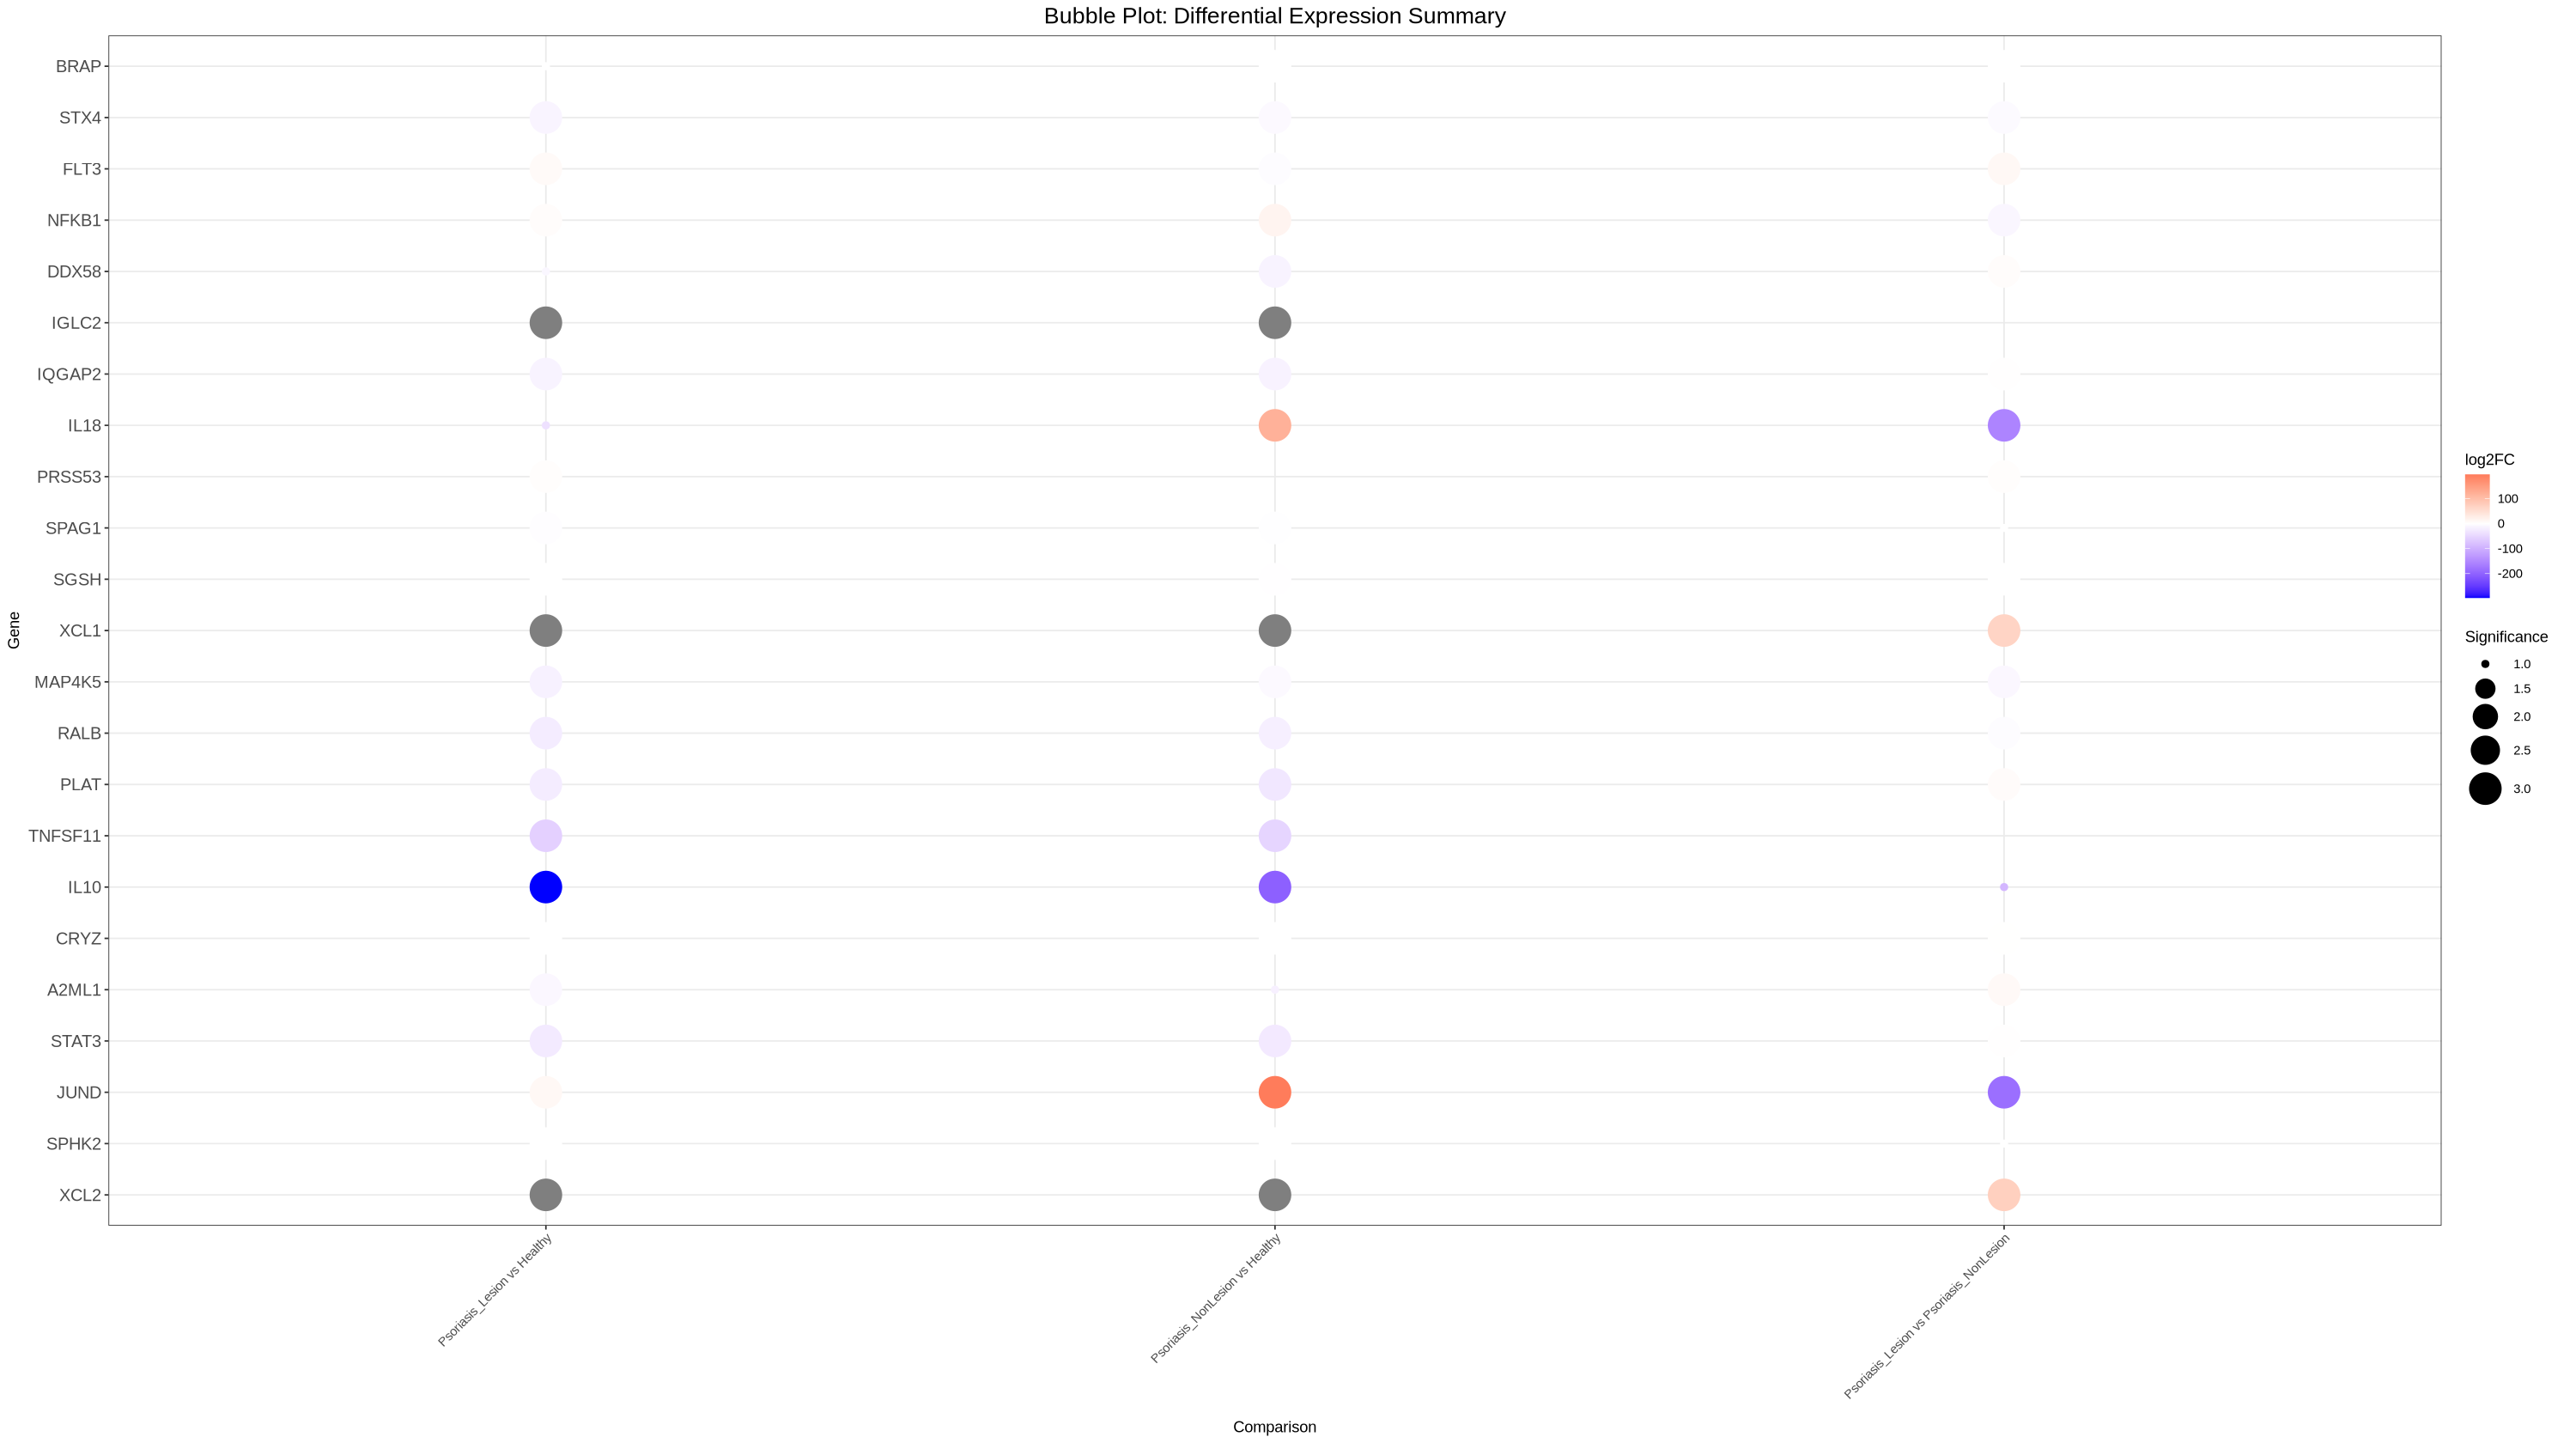

In [ ]:
library(ggplot2)
library(dplyr)

# Ensure correct column names
df <- all_de
colnames(df) <- gsub("\\.\\.\\.", "", colnames(df))
colnames(df) <- gsub("\\.", "_", colnames(df))

# Prepare categories
bubble_df <- df %>%
  mutate(
    Gene = factor(Gene, levels = rev(genes_present)),
    Comparison = factor(Comparison, levels = c(
      "Psoriasis_Lesion vs Healthy",
      "Psoriasis_NonLesion vs Healthy",
      "Psoriasis_Lesion vs Psoriasis_NonLesion"
    )),
    Significance = case_when(
      p_val_adj < 0.001 ~ 3,
      p_val_adj < 0.05  ~ 2,
      TRUE              ~ 1
    )
  )

bp <- ggplot(bubble_df, aes(
  x = Comparison,
  y = Gene,
  size = Significance,
  color = avg_log2FC
)) +
  geom_point() +
  scale_size(range = c(2, 10)) +
  scale_color_gradient2(low="blue", mid="white", high="red", midpoint=0) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle=45, hjust=1),
    axis.text.y = element_text(size=12),
    plot.title = element_text(size=16, hjust=0.5)
  ) +
  labs(
    title = "Bubble Plot: Differential Expression Summary",
    x = "Comparison",
    y = "Gene",
    size = "Significance",
    color = "log2FC"
  )

bp
ggsave("bubbleplot_DE_summary.pdf", bp, width=8, height=10)
ggsave("bubbleplot_DE_summary.png", bp, width=8, height=10, dpi=300)


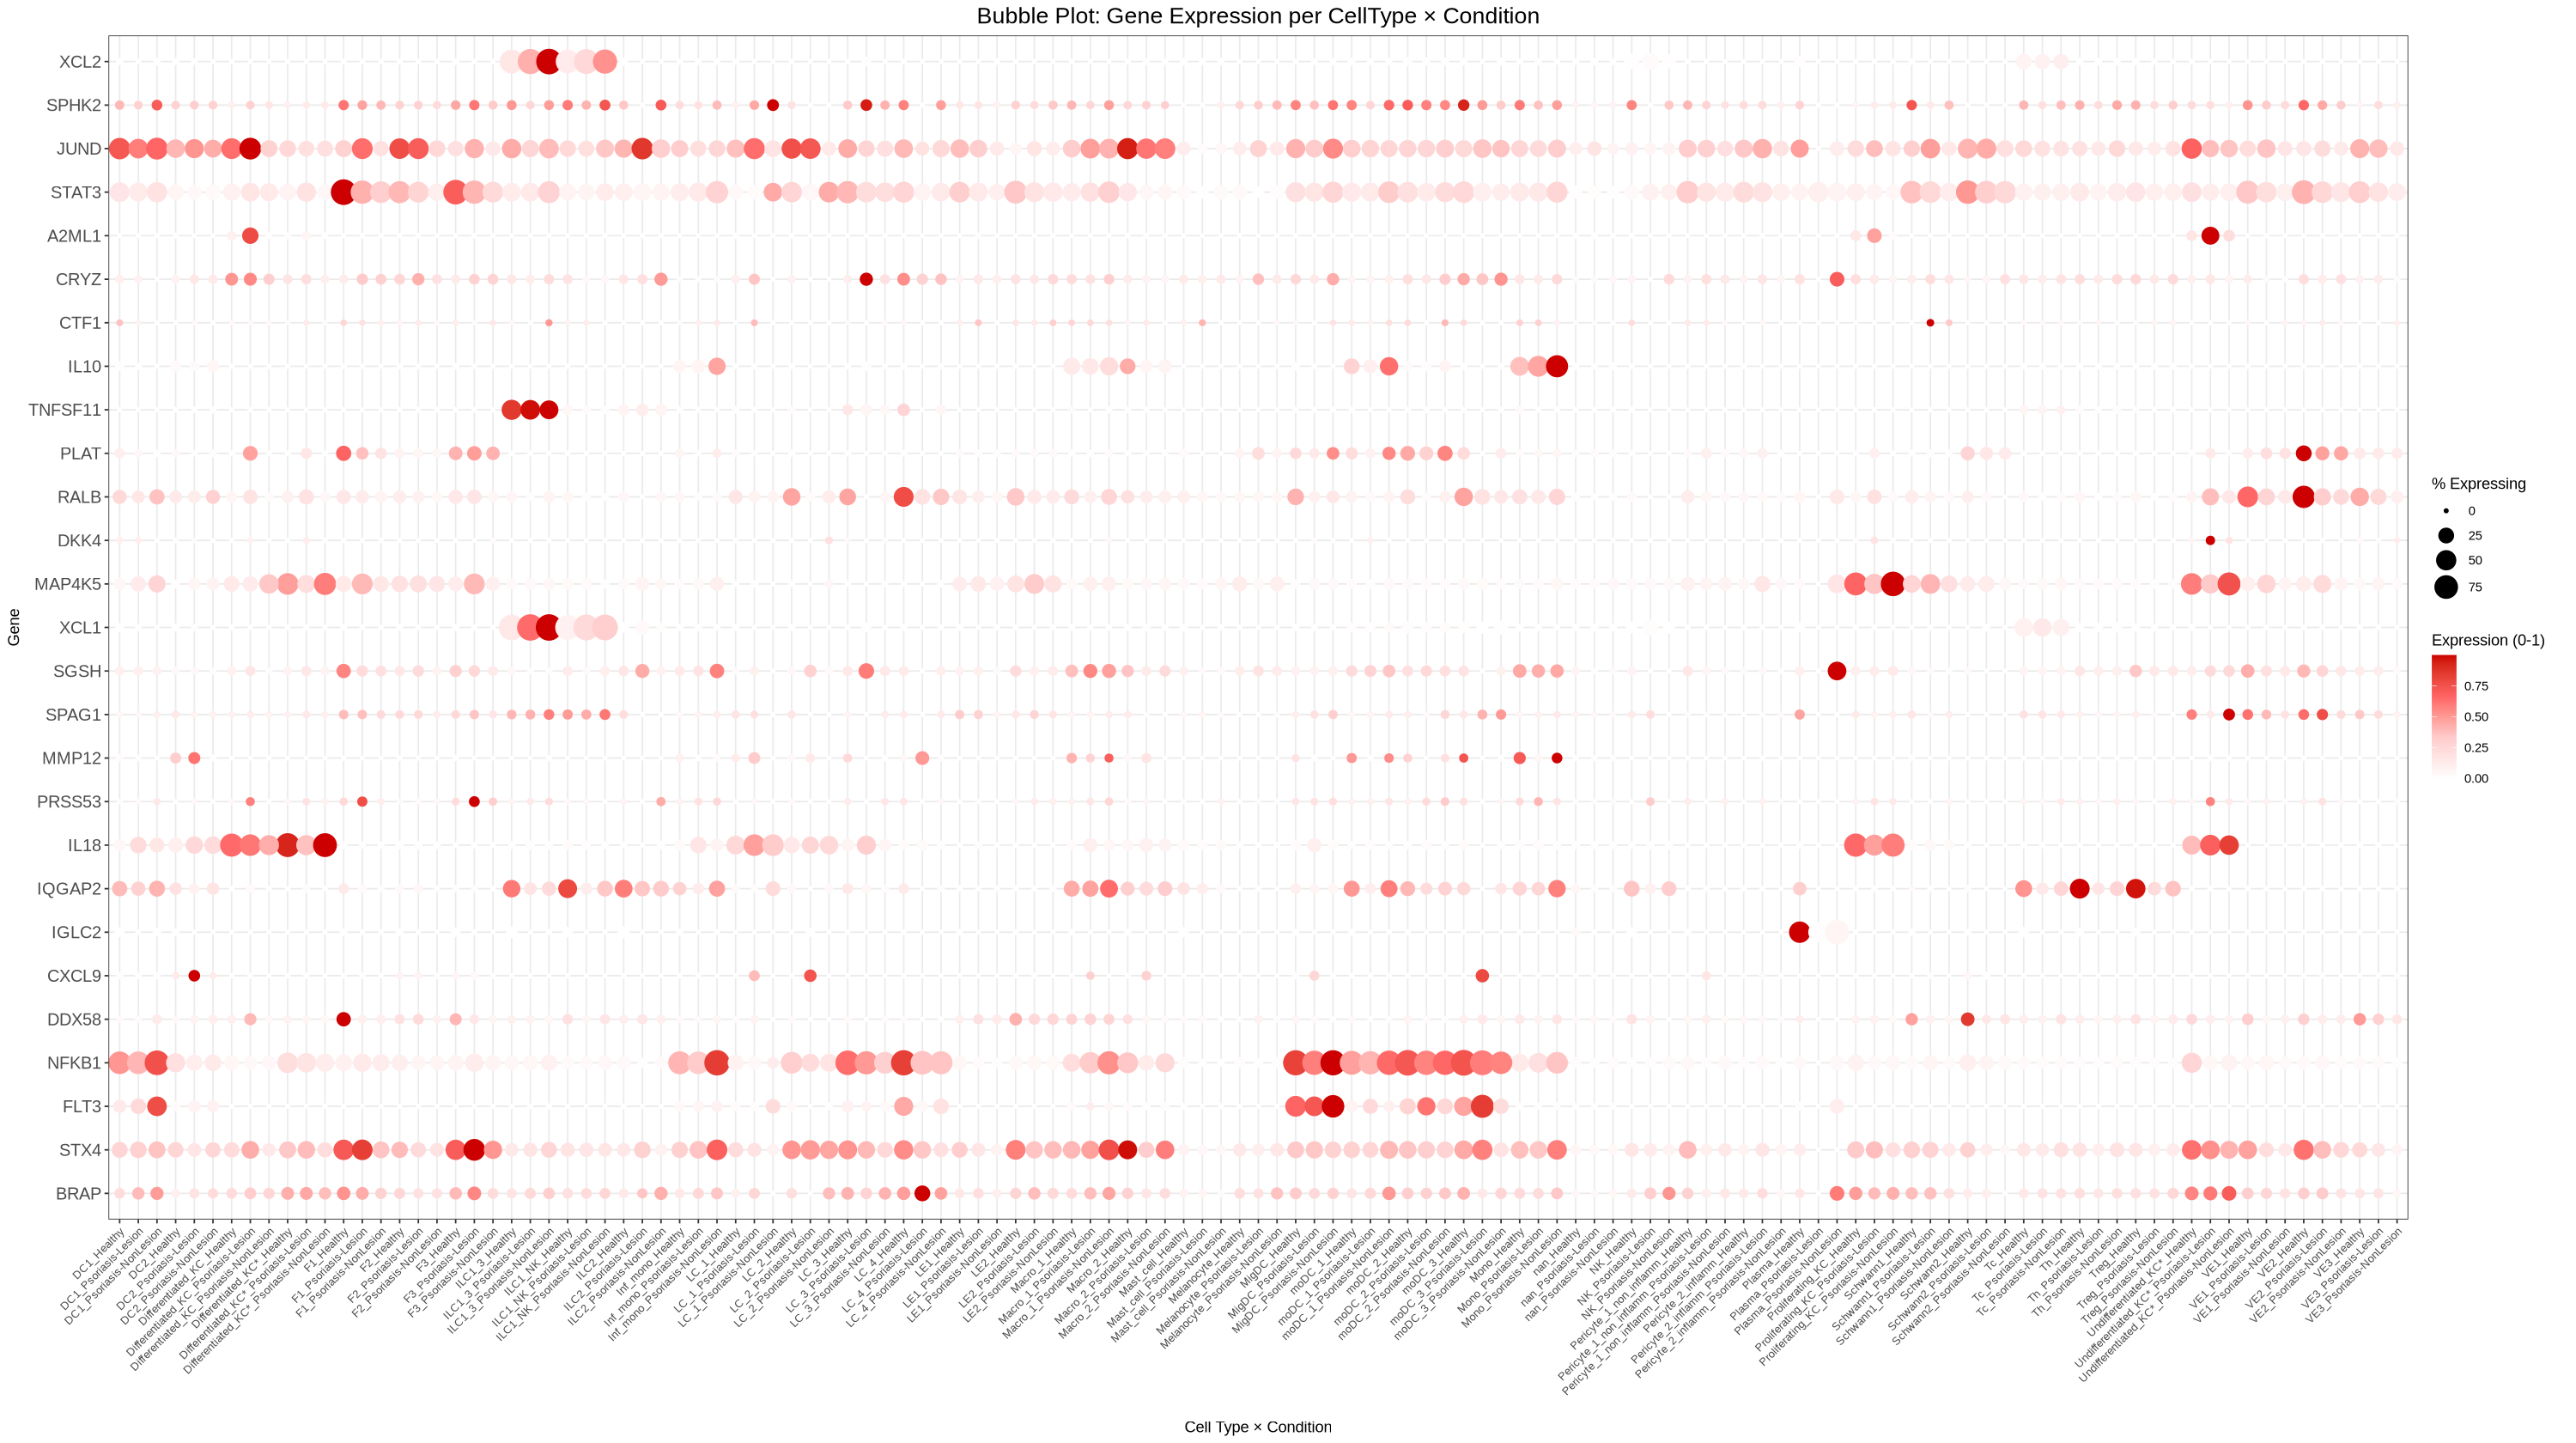

In [ ]:
library(ggplot2)
library(dplyr)

bubble2 <- ggplot(plot_df, aes(
  x = CellTypeCondition,
  y = Gene,
  size = Percent,
  color = Expression01
)) +
  geom_point() +
  scale_size(range = c(1, 8)) +
  scale_color_gradientn(
    colours = c("white", "#FFCCCC", "#FF6666", "#CC0000"),
    values  = c(0, 0.33, 0.66, 1)
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle=45, size=8, hjust=1),
    axis.text.y = element_text(size=12),
    plot.title = element_text(size=16, hjust=0.5)
  ) +
  labs(
    title = "Bubble Plot: Gene Expression per CellType × Condition",
    x = "Cell Type × Condition",
    y = "Gene",
    size = "% Expressing",
    color = "Expression (0-1)"  # <-- FIXED ASCII ONLY
)


bubble2
ggsave("bubbleplot_expression_CellTypeCondition.pdf", bubble2, width=22, height=12)
ggsave("bubbleplot_expression_CellTypeCondition.png", bubble2, width=22, height=12, dpi=300)


In [ ]:
library(Seurat)
library(dplyr)

# ================================================================
# 0. Setup Condition3 EXACTLY as you defined
# ================================================================
obj$Condition3 <- NA
obj$Condition3[obj$Status == "Healthy"] <- "Healthy"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "lesion"] <- "Psoriasis-Lesion"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "non_lesion"] <- "Psoriasis-NonLesion"

obj_sub <- subset(obj, Condition3 %in% c("Healthy","Psoriasis-Lesion","Psoriasis-NonLesion"))

# ================================================================
# 1. SAFE DE function — per cell type, all genes, min 3 cells
# ================================================================
run_de_celltype <- function(seu, celltype, g1, g2){

  # Check if cell type exists at all
  if (!celltype %in% seu$final_clustering) {
    message("Skipping ", celltype, " → cell type not present")
    return(NULL)
  }

  # Check if combination exists
  sel_cells <- which(
    seu$final_clustering == celltype &
    seu$Condition3 %in% c(g1, g2)
  )

  if (length(sel_cells) == 0) {
    message("Skipping ", celltype, " | ", g1, " vs ", g2, " → no cells found")
    return(NULL)
  }

  sub <- subset(seu,
                final_clustering == celltype &
                Condition3 %in% c(g1, g2))

  # Count cells
  n1 <- sum(sub$Condition3 == g1)
  n2 <- sum(sub$Condition3 == g2)

  if (n1 < 3 || n2 < 3) {
    message("Skipping ", celltype, " | ", g1, " vs ", g2,
            " → insufficient cells (", n1, " vs ", n2, ")")
    return(NULL)
  }

  # Identity groups
  Idents(sub) <- sub$Condition3

  # Run DE on ALL genes
  df <- FindMarkers(
    sub,
    ident.1 = g1,
    ident.2 = g2,
    logfc.threshold = 0,
    test.use = "wilcox",
    assay = "RNA",
    slot = "data"
  )

  df <- df %>%
    mutate(
      Gene = rownames(df),
      Comparison = paste0(g1, " vs ", g2),
      CellType = celltype,
      n_cells_group1 = n1,
      n_cells_group2 = n2,
      condition1 = g1,
      condition2 = g2,
      Significance_Class = case_when(
        p_val_adj < 0.001 ~ "Highly Significant",
        p_val_adj < 0.05  ~ "Significant",
        TRUE              ~ "Not Significant"
      )
    )

  rownames(df) <- NULL
  df
}

# ================================================================
# 2. RUN DE for each cell type × 3 comparisons
# ================================================================
celltypes <- sort(unique(obj_sub$final_clustering))

de_list <- list()

for (ct in celltypes) {

  # Lesion vs Healthy
  de_list[[paste0(ct, "_L_vs_H")]] <- run_de_celltype(
    obj_sub, ct,
    "Psoriasis-Lesion", "Healthy"
  )

  # NonLesion vs Healthy
  de_list[[paste0(ct, "_NL_vs_H")]] <- run_de_celltype(
    obj_sub, ct,
    "Psoriasis-NonLesion", "Healthy"
  )

  # Lesion vs NonLesion
  de_list[[paste0(ct, "_L_vs_NL")]] <- run_de_celltype(
    obj_sub, ct,
    "Psoriasis-Lesion", "Psoriasis-NonLesion"
  )
}

DE_celltypes <- bind_rows(de_list)

# ================================================================
# 3. SAVE TO CSV
# ================================================================
write.csv(
  DE_celltypes,
  "DE_per_celltype_allgenes_conditions_MIN3.csv",
  row.names = FALSE
)

message("DONE: DE per cell type between conditions (min 3 cells/group). Saved CSV.")


Warning message:
“Removing 174729 cells missing data for vars requested”
Skipping Plasma | Psoriasis-Lesion vs Healthy → insufficient cells (2 vs 71)

Skipping Plasma | Psoriasis-Lesion vs Psoriasis-NonLesion → insufficient cells (2 vs 5)

DONE: DE per cell type between conditions (min 3 cells/group). Saved CSV.

